In [303]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold,cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
from xgboost import XGBRegressor
import warnings

In [214]:
warnings.filterwarnings('ignore')

In [215]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [216]:
train_ID = train['Id']
test_ID = test['Id']

In [217]:
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

In [218]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [266]:
cormatrix = train.corr()
# plt.subplots(figsize =(12,12))
# sns.heatmap(cormatrix, vmin=-1, vmax=1, cbar=True, square=True, cmap='coolwarm')

In [267]:
# plt.subplots(figsize =(6,6))

corr_cols = cormatrix.nlargest(10, 'SalePrice')['SalePrice'].index
cormatrix2 = np.corrcoef(train[corr_cols].values.T)
sns.set(font_scale = 1.1)

# sns.heatmap(cormatrix2,cbar = True, square = True , 
#             cmap = 'coolwarm',annot_kws={'size': 10}, 
#             annot = True , xticklabels = corr_cols.values, 
#             yticklabels = corr_cols.values)

In [221]:
mostcor = pd.DataFrame(corr_cols) 
mostcor.columns = ['Most_Correlated_Features']

The features are described as follows.

OverallQual: Rates the overall material and finish of the house (1 = Very Poor, 10 = Very Excellent)

GrLivArea: Above grade (ground) living area square feet

GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

TotalBsmtSF: Total square feet of basement area

1stFlrSF: First Floor square feet

FullBath: Full bathrooms above grade

TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

YearBuilt: Original construction date

GarageCars and GarageArea are strongly correlated because the more cars that fit into a garage the more area there is in the garage.
We shall only use one Garage value in our model which is GarageCars since has a higher correlation value to SalePrice

OverallQual Has the highest correlation value to SalePrice because the overall quality of a house determines the selling price.

TotRmsAbvGrd is strongly correlated to GrLivArea because the area of living area above ground is related or determined mostly by the number of rooms above ground.Only one of these will be used
TotalBsmtSF and 1stFlrSF are strongly correlated because its likely that the size in area of the first floor determines the size of the basement.We will use TotalBsmtS

In [222]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

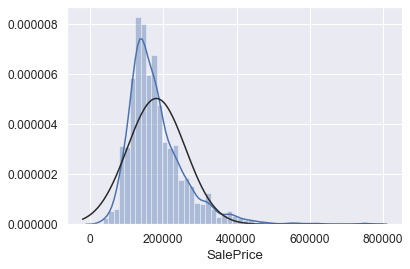

In [223]:
sns.distplot(train['SalePrice'], fit=norm)

In [224]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [225]:
train_num = train.shape[0]
test_num = test.shape[0]
y_train = train.SalePrice.values

In [226]:
data = pd.concat((train, test)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)
print("Concatenated dataframe size is :", (data.shape))

Concatenated dataframe size is : (2917, 79)


!MISSING VALUES

In [257]:
missing_df = pd.DataFrame({'Total':data.isnull().sum(), 'Percentage':(data.isnull().sum())/2917*100})
missing_df = missing_df.sort_values(by = 'Total',ascending = False)
missing_df = missing_df.loc[missing_df['Total'] > 0]
print(missing_df)

          Total  Percentage
SaleType      1    0.034282


In [283]:
data.shape

(2917, 227)

In [229]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence'):
    data.drop([col], axis = 1, inplace = True)

In [230]:
data.drop(['GarageArea','TotRmsAbvGrd', '1stFlrSF'], axis = 1, inplace = True)

In [231]:
data['LotFrontage'] = data.LotFrontage.fillna(data.LotFrontage.median())

In [232]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

In [233]:
for col in ('GarageYrBlt', 'GarageCars'):
    data[col] = data[col].fillna(0) 

In [234]:
for col in ('BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)   

In [235]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

In [236]:
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

In [237]:
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)    

In [238]:
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

In [239]:
data.drop(['Utilities'], axis=1, inplace = True)

In [240]:
data["Functional"] = data["Functional"].fillna("Typ")

In [252]:
data.Electrical = data['Electrical'].fillna('SBrkr')

In [255]:
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])

In [256]:
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

In [258]:
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

In [262]:
data.select_dtypes(include=['int64','float64']).columns

Index(['2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch',
       'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF',
       'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF',
       'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold'],
      dtype='object')

In [264]:
data.select_dtypes(include=['object']).columns

Index(['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu',
       'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual',
       'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType', 'Street'],
      dtype='object')

In [268]:
data['MSSubClass'] = data['MSSubClass'].apply(str)

In [269]:
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [282]:
for col in ('ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond'):
    print(col)
    print(data[col].value_counts())

ExterQual
2    1798
3     979
4     105
1      35
Name: ExterQual, dtype: int64
ExterCond
3    2536
4     299
2      67
5      12
1       3
Name: ExterCond, dtype: int64
BsmtQual
3    1283
4    1209
5     256
2      88
1      81
Name: BsmtQual, dtype: int64
BsmtCond
4    2604
5     122
3     104
1      82
2       5
Name: BsmtCond, dtype: int64
BsmtExposure
2    1904
4     418
5     274
3     239
1      82
Name: BsmtExposure, dtype: int64
BsmtFinType1
2    851
7    847
6    429
4    288
5    269
3    154
1     79
Name: BsmtFinType1, dtype: int64
BsmtFinType2
2    2491
4     105
3      87
1      80
5      68
6      52
7      34
Name: BsmtFinType2, dtype: int64
HeatingQC
5    1491
3     857
4     474
2      92
1       3
Name: HeatingQC, dtype: int64
KitchenQual
2    1493
3    1151
4     203
1      70
Name: KitchenQual, dtype: int64
FireplaceQu
1    1420
5     742
4     592
3      74
2      46
6      43
Name: FireplaceQu, dtype: int64
GarageQual
4    2602
1     159
3     124
5      24
2   

In [271]:
map1 = {'Po': 1, 'Fa': 2, 'TA': 3,'Gd': 4, 'Ex': 5}

for col in ('ExterCond', 'HeatingQC'):
    data[col] = data[col].map(map1)

In [273]:
map2 = {'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4,'Gd': 5, 'Ex': 6}

for col in ('GarageCond', 'GarageQual','FireplaceQu'):
    data[col] = data[col].map(map2)

In [274]:
map3 = {'None':1, 'Unf': 2, 'LwQ': 3, 'Rec': 4, 'BLQ': 5,'ALQ': 6, 'GLQ': 7}

for col in ('BsmtFinType2', 'BsmtFinType1'):
    data[col] = data[col].map(map3)

In [275]:
map4 = { 'Fa': 1, 'TA': 2,'Gd': 3, 'Ex': 4}

for col in ('ExterQual', 'KitchenQual'):
    data[col] = data[col].map(map4)

In [276]:
map5 = {'None': 1, 'Fa': 2, 'TA': 3,'Gd': 4, 'Ex': 5}
data['BsmtQual'] = data['BsmtQual'].map(map5)  

In [277]:
map6 = {'None': 1,'Po': 2, 'Fa': 3, 'TA': 4,'Gd': 5,}
data['BsmtCond'] = data['BsmtCond'].map(map6) 

In [278]:
map7 = {'None': 1,'No': 2, 'Mn': 3, 'Av': 4,'Gd': 5,}
data['BsmtExposure'] = data['BsmtExposure'].map(map7) 

In [279]:
cat_cols = ['BldgType', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
            'Exterior1st','Exterior2nd','Foundation', 'Functional','GarageFinish',
            'GarageType','Heating', 'HouseStyle',
            'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 
            'MSZoning','MasVnrType', 'Neighborhood', 'PavedDrive', 
            'RoofMatl', 'RoofStyle','SaleCondition', 'SaleType', 'Street','MoSold', 'YrSold',
             'MSSubClass']

In [281]:
data = pd.get_dummies(data, columns=cat_cols,prefix=cat_cols,drop_first=True )

In [286]:
num_feature = ['2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF',
               'EnclosedPorch','GrLivArea', 'GarageYrBlt','LotArea', 'LotFrontage',
               'LowQualFinSF', 'MasVnrArea',
               'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF',
               'WoodDeckSF','YearBuilt', 'YearRemodAdd']

In [287]:
skewness = data[num_feature].skew()
skewness = skewness[abs(skewness) > 0.75]
skewed_feature = skewness.index

In [290]:
for feature in skewed_feature:
    data[feature] = np.log1p(data[feature])

In [291]:
X_train = data[:1458]
X_test = data[1458:]

MODELLING

In [295]:
parameters = {  
                'colsample_bytree':[1],
                'subsample':[0.4,0.6],
                'gamma':[0.041],
                'min_child_weight':[1.1,1.3],
                'max_depth':[3,5],
                'learning_rate':[0.2, 0.25],
                'n_estimators':[400],                                                                    
                'reg_alpha':[0.75],
                'reg_lambda':[0.45],
                'seed':[10]
}

In [293]:
xgb_model = XGBRegressor()

In [297]:
grid_search = GridSearchCV(estimator = xgb_model,
                        param_grid = parameters,
                        scoring = 'neg_mean_squared_error',
                        cv = 5,
                        n_jobs = -1)
xgb_model = grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
accuracies = cross_val_score(estimator=xgb_model, X=X_train, y=y_train, cv=10)
accuracies.mean()

[14:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:50:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

-0.015473363305439757

In [311]:
best_parameters

{'colsample_bytree': 1,
 'gamma': 0.041,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 1.1,
 'n_estimators': 400,
 'reg_alpha': 0.75,
 'reg_lambda': 0.45,
 'seed': 10,
 'subsample': 0.6}

In [300]:
y_pred = xgb_model.predict(X_test)
y_pred = np.floor(np.expm1(y_pred))

In [309]:
submission = pd.concat([test_ID, pd.Series(y_pred)], 
                        axis=1,
                        keys=['Id','SalePrice'])

In [310]:
submission.to_csv('sample_submission_lr.csv', index = False)
